In [33]:
"""
author：算法进阶
https://github.com/aialgorithm/Blog
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [34]:
# 导入股票数据，选取股票开盘价序列数据
dataset_train = pd.read_csv('./data/NSE-TATAGLOBAL.csv')
dataset_train = dataset_train.sort_values(by='Date').reset_index(drop=True)
training_set = dataset_train.iloc[:, 1:2].values
print(dataset_train.shape)
dataset_train.head()


(2035, 8)


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
1,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
3,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
4,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [35]:
# 对训练数据max-min归一化，加速网络收敛
# max-min离差标准化帮助我们转化不同比例上的数据，消除特殊特征的主导。并且它不需要对数据的分布进行假设（比如k近邻和人工神经网络）。但是，归一化（离差标准化）不能很好地处理异常值。相反，标准化（中心标准化）可以更好地处理异常值，以及加速诸如梯度下降等算法的收敛。所以我们通常选择中心标准化。
from sklearn.preprocessing import MinMaxScaler,StandardScaler
# sc = StandardScaler()
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [36]:
# 数据整理为样本及标签：60 timesteps and 1 output
# 每条样本含60个时间步，对应下一时间步作为标签值
X_train = []
y_train = []
for i in range(60, 2035):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(1975, 60)
(1975,)


In [37]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(1975, 60, 1)


In [43]:
#  利用Keras创建RNN模型


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN,LSTM
from keras.layers import Dropout


# 初始化顺序模型
regressor = Sequential()


# 定义输入层及带5个神经元的隐藏层
regressor.add(SimpleRNN(units = 5,input_shape = (X_train.shape[1], 1)))

# regressor.add(SimpleRNN(units = 50,return_sequences=True,input_shape = (X_train.shape[1], 1)))  # 这样可以定义一个2*隐藏层的RNN
# regressor.add(SimpleRNN(units = 5))

# regressor.add(LSTM(units = 5,input_shape = (X_train.shape[1], 1)))   # 这样可以定义一个的LSTM
# 定义线性的输出层
regressor.add(Dense(units = 1))

# 模型编译：定义优化算法adam， 目标函数均方根MSE
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 模型训练
history = regressor.fit(X_train, y_train, epochs = 500, batch_size = 100, validation_split=0.3)

regressor.summary()

Train on 1382 samples, validate on 593 samples
Epoch 1/500
1382/1382 [==============================] - 0s 313us/step - loss: 0.0044 - val_loss: 0.0224
Epoch 2/500
1382/1382 [==============================] - 0s 71us/step - loss: 0.0010 - val_loss: 0.0262
Epoch 3/500
1382/1382 [==============================] - 0s 71us/step - loss: 8.0926e-04 - val_loss: 0.0245
Epoch 4/500
1382/1382 [==============================] - 0s 70us/step - loss: 7.4467e-04 - val_loss: 0.0243
Epoch 5/500
1382/1382 [==============================] - 0s 74us/step - loss: 6.9584e-04 - val_loss: 0.0224e-0
Epoch 6/500
1382/1382 [==============================] - 0s 77us/step - loss: 6.6056e-04 - val_loss: 0.0211
Epoch 7/500
1382/1382 [==============================] - 0s 72us/step - loss: 6.3523e-04 - val_loss: 0.0205
Epoch 8/500
1382/1382 [==============================] - 0s 75us/step - loss: 6.1188e-04 - val_loss: 0.0190
Epoch 9/500
1382/1382 [==============================] - 0s 71us/step - loss: 5.9054e-04 - va

Epoch 76/500
1382/1382 [==============================] - 0s 67us/step - loss: 2.2250e-04 - val_loss: 0.0037
Epoch 77/500
1382/1382 [==============================] - 0s 74us/step - loss: 2.2139e-04 - val_loss: 0.0036
Epoch 78/500
1382/1382 [==============================] - 0s 72us/step - loss: 2.1898e-04 - val_loss: 0.0036
Epoch 79/500
1382/1382 [==============================] - 0s 65us/step - loss: 2.1806e-04 - val_loss: 0.0037
Epoch 80/500
1382/1382 [==============================] - 0s 64us/step - loss: 2.1656e-04 - val_loss: 0.0036
Epoch 81/500
1382/1382 [==============================] - 0s 61us/step - loss: 2.1513e-04 - val_loss: 0.0035
Epoch 82/500
1382/1382 [==============================] - 0s 62us/step - loss: 2.1409e-04 - val_loss: 0.0036
Epoch 83/500
1382/1382 [==============================] - 0s 64us/step - loss: 2.1297e-04 - val_loss: 0.0034
Epoch 84/500
1382/1382 [==============================] - 0s 84us/step - loss: 2.1265e-04 - val_loss: 0.0034
Epoch 85/500
1382/1

1382/1382 [==============================] - 0s 73us/step - loss: 1.5422e-04 - val_loss: 0.0019
Epoch 225/500
1382/1382 [==============================] - 0s 75us/step - loss: 1.5507e-04 - val_loss: 0.0021
Epoch 226/500
1382/1382 [==============================] - 0s 71us/step - loss: 1.5017e-04 - val_loss: 0.0021
Epoch 227/500
1382/1382 [==============================] - 0s 64us/step - loss: 1.5052e-04 - val_loss: 0.0019
Epoch 228/500
1382/1382 [==============================] - 0s 66us/step - loss: 1.5221e-04 - val_loss: 0.0020
Epoch 229/500
1382/1382 [==============================] - 0s 65us/step - loss: 1.5068e-04 - val_loss: 0.0020
Epoch 230/500
1382/1382 [==============================] - 0s 65us/step - loss: 1.5121e-04 - val_loss: 0.0019
Epoch 231/500
1382/1382 [==============================] - 0s 68us/step - loss: 1.5417e-04 - val_loss: 0.0021
Epoch 232/500
1382/1382 [==============================] - 0s 64us/step - loss: 1.4935e-04 - val_loss: 0.0021
Epoch 233/500
1382/1382 

1382/1382 [==============================] - 0s 67us/step - loss: 1.4260e-04 - val_loss: 0.0018
Epoch 373/500
1382/1382 [==============================] - 0s 74us/step - loss: 1.4048e-04 - val_loss: 0.0018
Epoch 374/500
1382/1382 [==============================] - 0s 67us/step - loss: 1.4044e-04 - val_loss: 0.0018
Epoch 375/500
1382/1382 [==============================] - 0s 75us/step - loss: 1.4051e-04 - val_loss: 0.0019
Epoch 376/500
1382/1382 [==============================] - 0s 65us/step - loss: 1.3985e-04 - val_loss: 0.0018
Epoch 377/500
1382/1382 [==============================] - 0s 76us/step - loss: 1.4166e-04 - val_loss: 0.0019
Epoch 378/500
1382/1382 [==============================] - 0s 79us/step - loss: 1.4004e-04 - val_loss: 0.0017
Epoch 379/500
1382/1382 [==============================] - 0s 74us/step - loss: 1.4135e-04 - val_loss: 0.0019
Epoch 380/500
1382/1382 [==============================] - 0s 75us/step - loss: 1.4077e-04 - val_loss: 0.0019
Epoch 381/500
1382/1382 

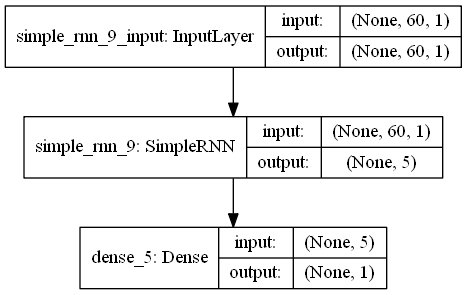

In [44]:
from keras.utils.vis_utils import plot_model

plot_model(regressor, show_shapes=True)

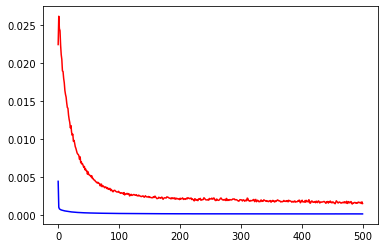

In [47]:

# 模型评估：拟合效果
plt.plot(history.history['loss'],c='blue')    # 蓝色线训练集损失
plt.plot(history.history['val_loss'],c='red') # 红色线验证集损失
plt.show()

In [45]:
# 评估模型测试集效果

# 测试数据
dataset_test = pd.read_csv('./data/tatatest.csv')
dataset_test = dataset_test.sort_values(by='Date').reset_index(drop=True)

real_stock_price = dataset_test.iloc[:, 1:2].values

dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

# 提取测试集
X_test = []
for i in range(60, 76):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 模型预测
predicted_stock_price = regressor.predict(X_test)
# 逆归一化
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# 模型评估
print('预测与实际差异MSE',sum(pow((predicted_stock_price - real_stock_price),2))/predicted_stock_price.shape[0])
print('预测与实际差异MAE',sum(abs(predicted_stock_price - real_stock_price))/predicted_stock_price.shape[0])

预测与实际差异MSE [53.03141531]
预测与实际差异MAE [5.82196445]


In [48]:
dataset_test.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749,3486.05
1,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590,3960.27
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786,3815.79
3,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515,7407.06
4,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146,10062.83


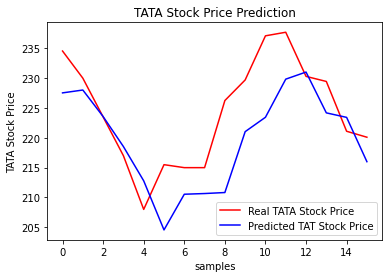

In [46]:
# 预测与实际差异的可视化
plt.plot(real_stock_price, color = 'red', label = 'Real TATA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TAT Stock Price')
plt.title('TATA Stock Price Prediction')
plt.xlabel('samples')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()